## Problem biznesowy  

### Opis zadania  
“Nasz serwis zarabia wtedy, gdy ludzie słuchają muzyki. Jeśli nie wiemy ile czasu będą słuchali jej w przyszłości, to trudno nam rozliczać się z artystami i negocjować z nimi stawki”.

### Definicja problemu biznesowego
1. Obecna sytuacja: Nie umiemy oszacować czasu słuchania artystów, a tym samym zysków, które przyniosą naszemu serwisowi. Utrudnia to rozliczanie i negocjowanie stawek.
2. Chcemy wprowadzić system szacowania czasu słuchania poszczególnych artystów, który:
    - analizując dane zebrane na temat artystów będzie szacował czas ich słuchania przez użytkowników
    - będzie przedstawiał tę informację w formie czytelnej dla człowkieka, np. w postaci krótkiego tekstu/tabelki
    - docelowo będzie funkcjonował jako serwis internetowy  

### Definicja zadania/zadań modelowania
- Należy zaprojektować **model regresji**, aproksymujący czas słuchania danego artysty przez użytkowników na podstawie danych o artystach, sesjach i słuchanych utworach  
- Dane do modelowania:  
    - Model będzie do przeprowadzenia predykcji brał pod uwagę dane z ostatnich 3 miesięcy.  
    - Dane zebrane do uczenia pochodzą z jednego roku (2023)  
    - Dane o artystach - posłużą do powiązania wyników modelu z konkretnym artystą (nasz model głównie operuje na danych z pliku sessions, w którym nie ma informacji o autorze utworu)  
    - Dane o utworach (czas trwania, popularność)  
    - Dane o sesjach:  
        - jak długo dany utwór był słuchany w kolejnych miesiącach  
        - czy utwór był przesłuchany w całości/przewinięty/polubiony  

### Definicja wszystkich założeń  
- Model będzie realizować **predykcje w skali miesiąca** (na miesiąc w przód)
- Model nie będzie uczył się ani przeprowadzał predykcji dla artystów, którzy nie byli w ogóle słuchani (nie gwarantujemy jakiejkolwiej jakości predykcji w takim przypadku)  
- Otrzymane dane zagregowano i przetworzono w następujący sposób:
    - wykorzystano tylko wybrane atrybuty z plików: artists, tracks i sessions - pozostałe nie mają znaczenia z punktu widzenia naszego zadania  
    - z pliku sessions usunięto wszystkie rekordy, które odpowiadały zdarzeniom nie będącym odtwarzaniem utworu (zakup konta premium, reklama)  
    - rekordy z pliku sessions zagregowano **ze względu na utwór** w następujący sposób:
        - zsumowano czasy odtworzeń w każdym miesiącu   
        - dane dla każdego miesiąca zapisano w oddzielnej kolumnie
- Projektowane modele nie będą działać na "surowych" danych zawartych w otrzymanych plikach, a na danych zagregowanych  
- Model będzie trenowany na dostępnych danych offline   
    - wstępnie planujemy do predykcji wykorzystać wszystkie wyżej wymienione atrybuty oraz dane o czasie słuchania artysty **z ostatnich 3 miesięcy** (przy czym zakładamy, że nie będziemy przewidywać czasu słuchania dla stycznia, lutego i marca, gdzie nie mamy dostępu do najważniejszych danych)  
    - dane do trenowania będą wybierane tak, aby przewidywania w procesie uczenia uwzględniały każdy miesiąc  
- Zadanie będzie realizowane przez **model regresji**  
    - model prosty (podstawowy) - **regresja liniowa**  
    - model złożony - **XGBoost**  (w pierwotnej wersji miał to być SVR, jednak w trakcie implementacji model ten dawał bardzo złe wyniki, dlatego postanowiliśmy go zmienić)  


### Zaproponowane kryteria sukcesu
- Biznesowe: Średnia różnica w przewidywaniach modelu, a faktycznym czasem słuchania artysty nie przekracza 6h (36 000 000 ms, ponieważ model operuje na milisekundach) w skali miesiąca w stosunku do rzeczywistej wartości  
- Analityczne: Takie samo jak biznesowe, osiągnięte na danych offline  
    - Model nie może zwracać stale tego samego, ani losowego wyniku - wynik musi w sposób deterministyczny wynikać z otrzymanych danych  
- Kryterium sukcesu zostało ustalone na modstawie przetestowania niedostrojonego modelu, który nauczono na otrzymanych danych  


## Skrypt demonstrujący wyniki dla niedostrojonego modelu  

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import pandas as pd

MONTH = 10 # pierwszy miesiąc, na który będą przeprowadzane predykcje (czyli miesiące 1-9 = dane trenujące, miesiące 10-11 = dane testujące)

def get_data():
    with open("data/aggregated.jsonl", "r") as file:
        return pd.read_json(file, lines=True)


def get_train_data(data: pd.DataFrame) -> pd.DataFrame:
    new_data = []
    for _, row in data.iterrows():
        for i in range(4, MONTH):
            row_data = {
                "popularity": row["popularity"],
                "time_played_3_months_before": row[f"time_played_month_{i - 3}"],
                "likes_3_months_before": row[f"likes_month_{i - 3}"],
                "play_without_skip_3_months_before": row[f"play_without_skip_month_{i - 3}"],
                "play_with_skip_3_months_before": row[f"play_with_skip_month_{i - 3}"],
                "time_played_2_month_before": row[f"time_played_month_{i - 2}"],
                "likes_2_months_before": row[f"likes_month_{i - 2}"],
                "play_without_skip_2_months_before": row[f"play_without_skip_month_{i - 2}"],
                "play_with_skip_2_months_before": row[f"play_with_skip_month_{i - 2}"],
                "time_played_1_month_before": row[f"time_played_month_{i - 1}"],
                "likes_1_month_before": row[f"likes_month_{i - 1}"],
                "play_without_skip_1_month_before": row[f"play_without_skip_month_{i - 1}"],
                "play_with_skip_1_month_before": row[f"play_with_skip_month_{i - 1}"],
                "month_to_predict": i,
                "time_played_to_predict": row[f"time_played_month_{i}"],
            }
            new_data.append(row_data)
    return pd.DataFrame(new_data)


def get_test_data(data: pd.DataFrame) ->pd.DataFrame:
    new_data = []
    for _, row in data.iterrows():
        for month in range(MONTH, 12):
            row_data = {
                "popularity": row["popularity"],
                "time_played_3_months_before": row[f"time_played_month_{month - 3}"],
                "likes_3_months_before": row[f"likes_month_{month - 3}"],
                "play_without_skip_3_months_before": row[f"play_without_skip_month_{month - 3}"],
                "play_with_skip_3_months_before": row[f"play_with_skip_month_{month - 3}"],
                "time_played_2_month_before": row[f"time_played_month_{month - 2}"],
                "likes_2_months_before": row[f"likes_month_{month - 2}"],
                "play_without_skip_2_months_before": row[f"play_without_skip_month_{month - 2}"],
                "play_with_skip_2_months_before": row[f"play_with_skip_month_{month - 2}"],
                "time_played_1_month_before": row[f"time_played_month_{month - 1}"],
                "likes_1_month_before": row[f"likes_month_{month - 1}"],
                "play_without_skip_1_month_before": row[f"play_without_skip_month_{month - 1}"],
                "play_with_skip_1_month_before": row[f"play_with_skip_month_{month - 1}"],
                "month_to_predict": month,
                "time_played_to_predict": row[f"time_played_month_{month}"],
            }
            new_data.append(row_data)
    return pd.DataFrame(new_data)


def get_data_for_model() -> tuple:
    data = get_data()

    train_data = get_train_data(data)
    train_data_list = [(row.to_list()[:-1], row.to_list()[-1]) for _, row in train_data.iterrows()]
    X_train = [exmpl[0] for exmpl in train_data_list]
    y_train = [exmpl[1] for exmpl in train_data_list]

    test_data = get_test_data(data)
    test_data_list = [(row.to_list()[:-1], row.to_list()[-1]) for _, row in test_data.iterrows()]
    X_test = [exmpl[0] for exmpl in test_data_list]
    y_test = [exmpl[1] for exmpl in test_data_list]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = get_data_for_model()

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

errors = []
for i in range(len(X_test)):
    perc_error = abs(y_test[i] - y_pred[i]) / y_test[i]
    errors.append(perc_error)

mae = mean_absolute_error(y_test, y_pred)
print(f"mae: {mae}ms = {mae / 3_600_000}h")

mae: 20694252.318517376ms = 5.748403421810382h


## Uwagi do 1 wersji danych:
1. Ogólne
    - Dużo błędów w danych - przykład: znaki typu \0 w imionach/nazwach, -1 w id artystów
    - Braki w danych - wartości typu null  
    - Bardzo mało danych dotyczących użytkowników w porównaniu do pozostałych
2. artists
    - id
        - Duża liczba niewłaściwych pól = -1 (aż 20%)
        - Pozostałe wartości są unikalne, brak pustych pól
    - name
        - Dużo błędów w nazwach artystów - 11% zawiera kodowanie binarne
        - Nie wszystkie pola są unikalne - około 30 wartości się powtarza maksymalnie 4 razy
    - genres
        - 20% pól jest pustych
        - niektóre gatunki są rozdzielane przecinkami, inne nie - następuje pewna niespójność
        - pytanie czy nie lepiej zastosować kodowanie wskaźnikowe? tzn. utworzyć atrybuty typu _classic, thai, pop_ o kodowaniu binarnym (0/1)
3. sessions:
    - timestamp
        - brak błędów i braków w danych
        - dużo mniej danych z pierwszych 7 miesięcy niż z ostatnich 3
    - user_id
        - 20% pól jest pustych 
        - dość nierównomiernie rozłożone - ponad 2tys danych dla niektórych użytkowników, mniej niż 200 dla innych
    - track_id
        - 20% pól jest pustych
    - event_type
        - brak błędów w danych
        - 20% pól jest pustych
    - session_id
        - brak błędów i braków w danych
4. tracks
    - id
        - 20% pól pustych
        - reszta pól unikalna
    - name
        - 20% pól pustych
        - 19% zawiera kodowanie binarne
    - popularity, duration_ms, explicit i release_date
        - brak pustych pól i błędów
    - id_artist
        - 20% pól pustych 
5. users
    - id
        - zupełnie przypadkowy i niepotrzebny atrybut
    - favourite_genres
        - 14 z 50 pól pustych  

## Uwagi do 2 wersji danych:
W 2 wersji danych została rozwiązana większość problemów (uzupełnione braki w danych, dużo mniej błędów w danych).
Nadal istniejące problemy:
- błedy w danych (wartości typu \0 w nazwach) -> po głębszej analizie doszliśmy do wniosku, że błędy te nie są krytyczne, gdyż same nazwy nie będą używane przez nasz model do predykcji  
- mała liczba użytkowników: Zauważyliśmy, że dane, które otrzymaliśmy w pliku sessions pochodzą zaledwie od 50 użytkowników. Podczas konsultacji z klientem dowiedzieliśmy się, że z serwisu korzysta ok. 200000 osób -> uznaliśmy, że dane od tak małej grupy są niereprezentatywne, dlatego zdecydowaliśmy się poprosić o kolejną wersję

## Analiza 3 (ostatecznej) wersji danych   



**Potrzebne pakiety i zmienne**

In [3]:
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
jsonl_file_path_sessions = 'data/IUM23Z_Zad_06_01_v3/sessions.jsonl'
jsonl_file_path_artists = 'data/IUM23Z_Zad_06_01_v3/artists.jsonl'
jsonl_file_path_tracks = 'data/IUM23Z_Zad_06_01_v3/tracks.jsonl'
jsonl_file_path_tracks_full_info = 'data/IUM23Z_Zad_06_01_v3/tracks_full_info.jsonl'

/home/nel/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Artists

In [2]:
df_artists = pd.read_json(jsonl_file_path_artists, lines=True)
print("Ogólny opis danych:\n", "\t liczba pól:", len(df_artists), "\n", df_artists.describe(), "\n")
print("Liczba pustych pól genres: ", df_artists["genres"].isnull().sum(), "\n")
genres = []
for index, row in df_artists.iterrows():
    for genre in row["genres"]:
        if genre not in genres:
            genres.append(genre)
print("Gatunki:", genres)
print("Liczba gatunków: ", len(genres), "\n")

Ogólny opis danych:
 	 liczba pól: 27650 
                             id   name            genres
count                    27650  27650             27650
unique                   27650  27542             13704
top     72578usTM6Cj5qWsi471Nc    TNT  [indonesian pop]
freq                         1      4                74 

Liczba pustych pól genres:  0 

Gatunki: ['filmi', 'indian folk', 'indian rock', 'kannada pop', 'desi pop', 'hindi indie', 'indian indie', 'new delhi indie', 'sufi', 'modern bollywood', 'opm', 'pinoy hip hop', 'pinoy r&b', 'pinoy trap', 'tagalog rap', 'indian singer-songwriter', 'vintage tango', 'villancicos', 'rock nacional', 'argentine rock', 'italian progressive rock', 'argentine metal', 'latin metal', 'chamame', 'folklore argentino', 'charango', 'folclore jujeno', 'world chill', 'cumbia santafesina', 'argentine indie', 'indie platense', 'folclore salteno', 'rock en espanol', 'post-punk argentina', 'cuarteto', 'argentine punk', 'cumbia villera', 'argentine heavy m

**Uwagi i problemy**:
- Już nie ma pustych pól w atrybucie genres
- Już id przybiera właściwe wartości (nie ma błędów możliwych do wykrycia)
- Id: jest unikalnym atrybutem dyskretnym reprezentującym artystę, powinno wskazać nam, że dane się nie powtarzają -  tzn. kolejne rekordy dotyczą innych osób - pytanie czy to prawda, jako że atrybut "name" się czasem powtarza.   
- Genres: jest atrybutem dyskretnym, reprezentującym gatunki muzyczne. Jest to atrybut "wektorowy". Dane trzeba dostosować, jednakże, ponieważ jest ich dużo, nie możemy zastosować kodowania wskaźnikowego

    
### Sessions

Nie badamy niepotrzebnych danych- czyli te co nie mają 'play', 'skip', 'like' w 'event_type'.   
Nie uruchamiać bez potrzeby, zajmuje ok. 2min

In [14]:
n_rows = 32200670
df_sessions_json_reader = pd.read_json(jsonl_file_path_sessions, lines=True, chunksize=100000)
print("")
n_records = 0
null_track_id = 0
user_idlist = []
number_of_records_in_months = {i:0 for i in range(1, 13)}
for i, df_sessions in enumerate(df_sessions_json_reader):
    print("Chunk: ", i, "\n")
    cleaned_df_sessions = df_sessions[df_sessions['event_type'].isin(('play', 'skip', 'like'))]
    del df_sessions
    n_records += len(cleaned_df_sessions)
    if i>0:
        min_timestamp = min(min_timestamp, cleaned_df_sessions["timestamp"].min())
        max_timestamp = max(max_timestamp, cleaned_df_sessions["timestamp"].max())
    else:
        min_timestamp = cleaned_df_sessions["timestamp"].min()
        max_timestamp = cleaned_df_sessions["timestamp"].max()
    for i in range(1, 13):
        number_of_records_in_months[i] += len(cleaned_df_sessions[cleaned_df_sessions["timestamp"].dt.month == i])
    unique_user_id = cleaned_df_sessions["user_id"].unique()
    null_track_id += cleaned_df_sessions["track_id"].isnull().sum()
    for user_id in unique_user_id:
        user_idlist.append(user_id) if user_id not in user_idlist else None
    del cleaned_df_sessions

print("Liczba rekordów: ", n_records, "\n")
print("Timestamp min: ", min_timestamp, "\n")
print("Timestamp max: ", max_timestamp, "\n")
print("Timestamp liczba wystąpień dla danego miesiąca: ", number_of_records_in_months , "\n")
print("Liczba unikalnych user_id: ", len(user_idlist), "\n")
print("Liczba pustych pól track_id: ", null_track_id, "\n")



Liczba rekordów:  29736294 

Timestamp min:  2023-01-02 08:10:27.223932 

Timestamp max:  2023-12-04 02:18:14.761321 

Timestamp liczba wystąpień dla danego miesiąca:  {1: 193721, 2: 589907, 3: 1115373, 4: 1636400, 5: 2102240, 6: 2567962, 7: 3294561, 8: 3663162, 9: 4174128, 10: 4707303, 11: 5001853, 12: 689684} 

Liczba unikalnych user_id:  3000 

Liczba pustych pól track_id:  0 



**Uwagi i problemy**

- brak widocznych błędów i braków


### Tracks


In [3]:
df_tracks = pd.read_json(jsonl_file_path_tracks, lines=True)
df_tracks["duration_ms"] = df_tracks["duration_ms"].astype('Int64')
df_tracks["popularity"] = df_tracks["popularity"].astype('Int64')
print("Ogólny opis danych:\n", "\t liczba pól:", len(df_tracks), "\n")
print("Opis id: \n", "\tLiczba pól: ", df_tracks["id"].count(), "\n\tLiczba unikalnych wartości: ", len(df_tracks["id"].unique()), "\n")
print("Opis popularity: \n", "\ttyp: dyskretny porządkowy\n\tmax: ", (df_tracks["popularity"].max()), "\n\tmin: ", (df_tracks["popularity"].min()), "\n\tśrednia: ", df_tracks["popularity"].mean(), "\n\tmediana: ", int(df_tracks["popularity"].median()), "\n")
print("Opis duration_ms: \n", "\ttyp: na razie dyskretny\n", df_tracks["duration_ms"].describe().astype('Int64'), "\n")
print("Opis release_date: \n", "\ttyp: dyskretny porządkowy\n\tmax: ", df_tracks["release_date"].max(), "\n\tmin: ",
      df_tracks["release_date"].min(), "\n\tliczba dat w formacie 'YYYY': ", df_tracks['release_date'].str.count(r'^\d{4}$').sum() ,
      "\n\tliczba dat w formacie 'YYYY-MM': ", df_tracks['release_date'].str.count(r'^\d{4}-\d{2}$').sum(),
      "\n\tliczba dat w formacie 'YYYY-MM-DD': ", df_tracks['release_date'].str.count(r'^\d{4}-\d{2}-\d{2}$').sum(), "\n")
print("Opis id_artist: \n\ttyp: dyskretny\n", df_tracks["id_artist"].describe(), "\nliczba artist_id występująca tylko raz: ", df_tracks["id_artist"].value_counts()[df_tracks["id_artist"].value_counts() == 1].count(), "\n")

Ogólny opis danych:
 	 liczba pól: 129648 

Opis id: 
 	Liczba pól:  129648 
	Liczba unikalnych wartości:  129648 

Opis popularity: 
 	typ: dyskretny porządkowy
	max:  97 
	min:  0 
	średnia:  29.70743860298655 
	mediana:  29 

Opis duration_ms: 
 	typ: na razie dyskretny
 count     129648
mean      228169
std       109372
min         4000
25%       177400
50%       216787
75%       263267
max      4027622
Name: duration_ms, dtype: Int64 

Opis release_date: 
 	typ: dyskretny porządkowy
	max:  2021-04-16 
	min:  1922 
	liczba dat w formacie 'YYYY':  29162 
	liczba dat w formacie 'YYYY-MM':  621 
	liczba dat w formacie 'YYYY-MM-DD':  99865 

Opis id_artist: 
	typ: dyskretny
 count                     129648
unique                     27650
top       3meJIgRw7YleJrmbpbJK6S
freq                        1185
Name: id_artist, dtype: object 
liczba artist_id występująca tylko raz:  12065 



**Uwagi i problemy**
- atrybut id wskazuje na to, że rekordy "są unikalne" - dotyczą jednej piosenki
- atrybut name nie powinien nam być potrzebny. To, że nie jest unikalny to nie jest problem - wiele piosenek może mieć tę samą nazwę
- atrybut popularity - typ dyskretny porządkowy, będzie na pewno bardzo ważnym atrybutem, wydaje się być poprawny - należy dopytać co oznacza
- atrybut duration_ms - typ dyskretny, będzie na pewno bardzo ważnym atrybutem, wydaje się być poprawny, ze względu na ilość można by zmienić na atrybut ciągły
- atrybut id_artist - typ dyskretny, wskazuje konkrentego artystę (łączy z plikiem "artists.jsonl"), może być problem z tym, że niektórzy artyści mają tylko 1 utwór

### Dokładniejsza analiza
Definiujemy funkcje korelacji

In [4]:
def Spearman_correlation(a, b):
    a_ranks = [sorted(range(len(a)), key=lambda k: a[k]), [0] * len(a)]
    b_ranks = [sorted(range(len(b)), key=lambda k: b[k]), [0] * len(b)]
    for i in range(len(a)):
        a_ranks[1][a_ranks[0][i]] = i + 1
    for i in range(len(b)):
        b_ranks[1][b_ranks[0][i]] = i + 1
    rank_diff = [r1 - r2 for r1, r2 in zip(a_ranks[1], b_ranks[1])]
    n = len(a)
    spearman_correlation1 = 1 - (6 * sum([d ** 2 for d in rank_diff]) / (n * (n ** 2 - 1)))
    return spearman_correlation1

Obliczamy konkretne wartości (czasu oddtwarzania w danym miesiącu etc) i zapisujemy do pliku, aby już więcej nie operować na tak dużych danych.  
Uwaga- generowanie zajmuje ok. 5min

In [6]:
track_full_info= df_tracks.set_index('id')[['popularity', 'duration_ms', 'id_artist', 'release_date']].to_dict(orient='index')

for _, value in track_full_info.items():
    for i in range(1, 13):
        value[f'time_played_month_{i}'] = 0
        value[f'likes_month_{i}'] = 0
        value[f'play_without_skip_month_{i}'] = 0
        value[f'play_with_skip_month_{i}'] = 0
df_sessions_json_reader = pd.read_json(jsonl_file_path_sessions, lines=True, chunksize=100000)
for i, df_sessions in enumerate(df_sessions_json_reader):
    print("Chunk: ", i, end="\r")
    sessions = df_sessions[ df_sessions['event_type'].isin(['play', 'skip', 'like'])].sort_values(by=['session_id', 'timestamp']).to_dict(orient='records')
    index = 0
    while index < len(sessions):
        session = sessions[index]
        next_index = index + 1
        if session['event_type'] == 'play':
            month_number = session['timestamp'].month
            if next_index < len(sessions) and sessions[next_index]['session_id'] == session['session_id'] and sessions[next_index]['event_type'] == 'skip':
                track_full_info[session['track_id']][f'time_played_month_{month_number}'] += (sessions[next_index]['timestamp'] - session['timestamp']).total_seconds()*1000
                track_full_info[session['track_id']][f'play_with_skip_month_{month_number}'] += 1
                next_index += 1
            elif next_index < len(sessions) and sessions[next_index]['track_id'] == session['track_id'] and sessions[next_index]['event_type'] == 'like':
                track_full_info[session['track_id']][f'likes_month_{month_number}'] += 1
                next_index += 1
            else:
                track_full_info[session['track_id']][f'time_played_month_{month_number}'] += track_full_info[session['track_id']]['duration_ms']
                track_full_info[session['track_id']][f'play_without_skip_month_{month_number}'] += 1
        index = next_index

df = pd.DataFrame.from_dict(track_full_info, orient='index')
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'track_id'})
df.to_json('data/IUM23Z_Zad_06_01_v3/tracks_full_info.jsonl', orient='records', lines=True)
del df, track_full_info, sessions, df_sessions


Właściwe liczenie korelacji:

In [7]:
track_full_info = pd.read_json(jsonl_file_path_tracks_full_info, lines=True).set_index('track_id').to_dict(orient='index')
popularity_values = [value['popularity'] for value in track_full_info.values()]
duration_values = [value['duration_ms'] for value in track_full_info.values()]
table_spearman = PrettyTable()
table_spearman.field_names = ["Miesiąc", "Time_played (suma)", "Popularity (średnia)", "Likes (liczba)", "Duration_ms", "Play bez Skip (liczba)", "Play z Skip (liczba)"]
for j in range(1,10):
    for i in range(1, 13-j):
        now_time_played = [value[f'time_played_month_{i}'] for value in track_full_info.values()]
        czas_values = [value[f'time_played_month_{i+j}'] for value in track_full_info.values()]
        likes_values = [value[f'likes_month_{i}'] for value in track_full_info.values()]
        play_whithout_skip_values = [value[f'play_without_skip_month_{i}'] for value in track_full_info.values()]
        play_with_skip_values = [value[f'play_with_skip_month_{i}'] for value in track_full_info.values()]
        table_spearman.add_row([i,
                    Spearman_correlation(now_time_played, czas_values),
                    Spearman_correlation(popularity_values, czas_values),
                    Spearman_correlation(czas_values, likes_values),
                    Spearman_correlation(czas_values, duration_values),
                    Spearman_correlation(czas_values, play_whithout_skip_values),
                    Spearman_correlation(czas_values, play_with_skip_values)])
    if j == 1:
        print("Korelacja Spearmana pomiędzy atrybutami a czasem odtwarzania utworu w następnym miesiącu:")
    else:
        print("Korelacja Spearmana pomiędzy atrybutami a czasem odtwarzania utworu za", j, "miesiące/y:")
    print(table_spearman, "\n")
    table_spearman.clear_rows()

Korelacja Spearmana pomiędzy atrybutami a czasem odtwarzania utworu w następnym miesiącu:
+---------+--------------------+----------------------+--------------------+----------------------+------------------------+----------------------+
| Miesiąc | Time_played (suma) | Popularity (średnia) |   Likes (liczba)   |     Duration_ms      | Play bez Skip (liczba) | Play z Skip (liczba) |
+---------+--------------------+----------------------+--------------------+----------------------+------------------------+----------------------+
|    1    | 0.9962281678594067 |  0.070942109112065   | 0.9693942426073271 | 0.03978809158487662  |   0.9658317607973804   |  0.9806778259572598  |
|    2    | 0.9998307938939662 | 0.07104629349817215  | 0.9980538758666397 | 0.04027941058616613  |   0.9934003487119398   |  0.9992316076517217  |
|    3    | 0.9998826960758813 | 0.07104960057760068  | 0.9995046815659803 | 0.040482645416176744 |   0.998348023371386    |  0.9995927444573579  |
|    4    | 0.99990824

Możemy stwierdzić że jest mała zależność liniowa między popularity a time_played, bardzo mała między duration_ms a time_played, ale bardzo duża między likes a time_played.  
Oznacza to, że mamy dużą zależność liniową między likes a time_played.   
Oddzielnie sprawdziliśmy korelację liniową między likes a popularity - wynosiła ok. 0.07 dla Spearmana i 0.1 dla liniowej.  

Podobne obliczenia dla artysty

In [8]:
df_artists = pd.read_json(jsonl_file_path_artists, lines=True)
artists_full_info = df_artists.set_index('id')[['genres']].to_dict(orient='index')
track_full_info = pd.read_json(jsonl_file_path_tracks_full_info, lines=True).set_index('track_id').to_dict(orient='index')
for _, value in artists_full_info.items():
    for i in range(1, 13):
        value[f'time_played_month_{i}'] = 0
        value[f'likes_month_{i}'] = 0
        value[f'play_without_skip_month_{i}'] = 0
        value[f'play_with_skip_month_{i}'] = 0
    value['popularity_sum'] = 0
    value['popularity_number'] = 0
for key, value in track_full_info.items():
    artists_full_info[value['id_artist']]['popularity_sum'] += value['popularity']
    artists_full_info[value['id_artist']]['popularity_number'] += 1
    for i in range(1, 13):
        artists_full_info[value['id_artist']][f'time_played_month_{i}'] += value[f'time_played_month_{i}']
        artists_full_info[value['id_artist']][f'likes_month_{i}'] += value[f'likes_month_{i}']
        artists_full_info[value['id_artist']][f'play_with_skip_month_{i}'] += value[f'play_with_skip_month_{i}']
        artists_full_info[value['id_artist']][f'play_without_skip_month_{i}'] += value[f'play_without_skip_month_{i}']
for _, value in artists_full_info.items():
    value['popularity_avg'] = value['popularity_sum'] / value['popularity_number']

table_spearman = PrettyTable()
table_spearman.field_names = ["Miesiąc", "Time_played (suma)", "Popularity (średnia)", "Likes (liczba)", "Play bez Skip (liczba)", "Play z Skip (liczba)"]


#korelacje
popularity_values = [value['popularity_avg'] for value in artists_full_info.values()]
for j in range(1, 10):
    sums_correlation = {"now_time_played_spearman": 0, "popularity_spearman": 0, "likes_spearman": 0, "play_whithout_skip_spearman": 0, "play_with_skip_spearman": 0}
    for i in range(1, 13-j):
        now_time_played = [value[f'time_played_month_{i}'] for value in artists_full_info.values()]
        czas_values = [value[f'time_played_month_{i+j}'] for value in artists_full_info.values()]
        likes_values = [value[f'likes_month_{i}'] for value in artists_full_info.values()]
        play_whithout_skip_values = [value[f'play_without_skip_month_{i}'] for value in artists_full_info.values()]
        play_with_skip_values = [value[f'play_with_skip_month_{i}'] for value in artists_full_info.values()]
        correlation_spearman_now_time_played = Spearman_correlation(now_time_played, czas_values)
        correlation_spearman_popularity = Spearman_correlation(popularity_values, czas_values)
        correlation_spearman_likes = Spearman_correlation(czas_values, likes_values)
        correlation_spearman_play_whithout_skip = Spearman_correlation(czas_values, play_whithout_skip_values)
        correlation_spearman_play_with_skip = Spearman_correlation(czas_values, play_with_skip_values)
        sums_correlation["now_time_played_spearman"] += correlation_spearman_now_time_played
        sums_correlation["popularity_spearman"] += correlation_spearman_popularity
        sums_correlation["likes_spearman"] += correlation_spearman_likes
        sums_correlation["play_whithout_skip_spearman"] += correlation_spearman_play_whithout_skip
        sums_correlation["play_with_skip_spearman"] += correlation_spearman_play_with_skip
        table_spearman.add_row([i,
                        correlation_spearman_now_time_played,
                        correlation_spearman_popularity,
                        correlation_spearman_likes,
                        correlation_spearman_play_whithout_skip,
                        correlation_spearman_play_with_skip])
    table_spearman.add_row(["avg",
                            sums_correlation["now_time_played_spearman"]/(12-j),
                            sums_correlation["popularity_spearman"]/(12-j),
                            sums_correlation["likes_spearman"]/(12-j),
                            sums_correlation["play_whithout_skip_spearman"]/(12-j),
                            sums_correlation["play_with_skip_spearman"]/(12-j)])
    print("Korelacja spearmana pomiędzy atrybutami a sumarycznym czasem odtwarzania artysty za", j, "miesiąc/y/e:")
    print(table_spearman, "\n")
    table_spearman.clear_rows()


Korelacja spearmana pomiędzy atrybutami a sumarycznym czasem odtwarzania artysty za 1 miesiąc/y/e:
+---------+--------------------+----------------------+--------------------+------------------------+----------------------+
| Miesiąc | Time_played (suma) | Popularity (średnia) |   Likes (liczba)   | Play bez Skip (liczba) | Play z Skip (liczba) |
+---------+--------------------+----------------------+--------------------+------------------------+----------------------+
|    1    | 0.9998717087291821 | 0.15085952621061038  | 0.9991151999494648 |   0.9983027663204129   |  0.9992178072300112  |
|    2    | 0.9999998216812716 | 0.15085721369218064  | 0.9999700037118475 |   0.9997401826058333   |  0.9999984024101065  |
|    3    | 0.9999998877767768 | 0.15085409994406807  | 0.9999955180102696 |   0.9999933707706239   |  0.9999984069452211  |
|    4    | 0.9999999172473578 |  0.1508560627159854  | 0.9999995275226952 |   0.9999993100988926   |  0.9999982949944795  |
|    5    | 0.999999932119

### Wnioski z analizy danych
- istnieje duża zależność monotoniczna między funkcją celu, a liczbą polubień wpoprzednich miesiącach i czasem odtwarzania artysty w poprzednich miesiącach -> będą to potencjalnie najbardziej wartościowe (informatywne) atrybuty  
- w przypadku pozostałych atrybutów nie występuje żadna bardzo silna zależność monotoniczna między nimi, a funkcją, jednak zostaną one użyte w celu zbalansowania wpływu najbardziej istotnych atrybutów  
- trzecia wersja danych wydaje się być odpowiednia do trenowania modelu  

### Rozkład atrybutów
#### Atrybuty oryginalne (niezagregowane)
**Artists**

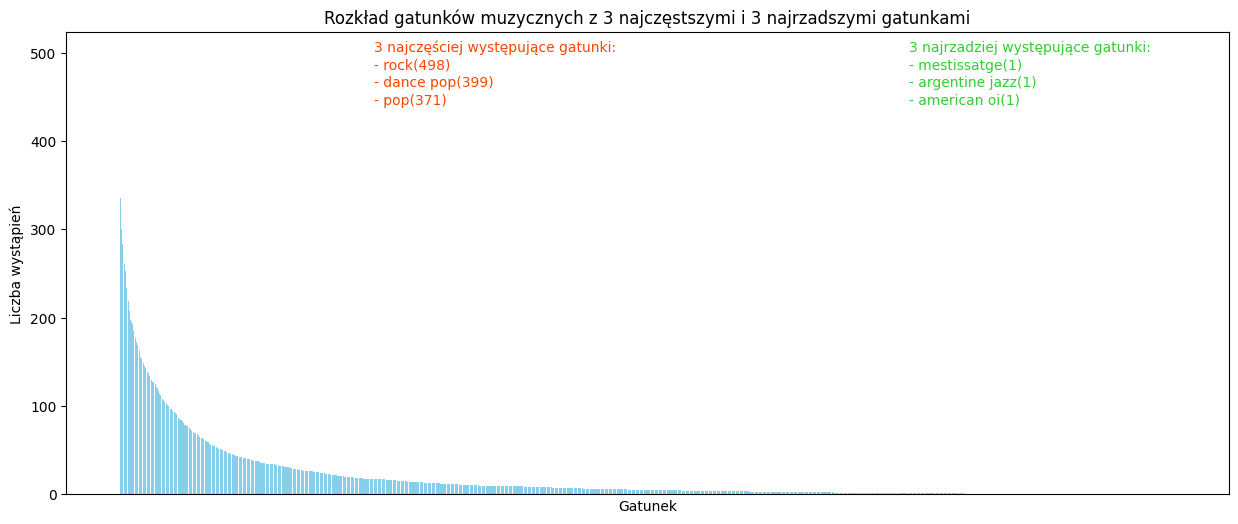

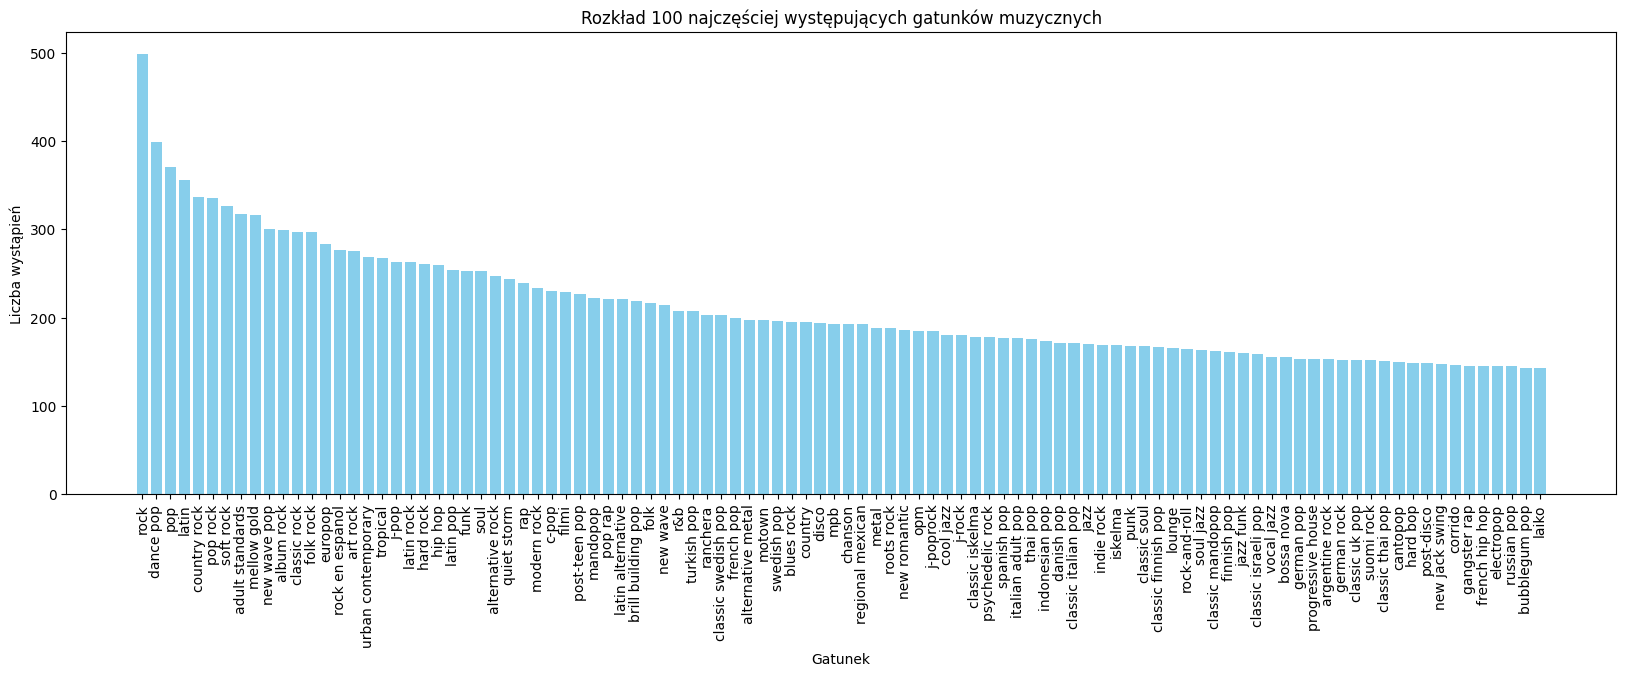

In [37]:
df_artists = pd.read_json(jsonl_file_path_artists, lines=True)
genres = {}
for index, row in df_artists.iterrows():
    for genre in row["genres"]:
        if genre not in genres:
            genres[genre] = 1
        else:
            genres[genre] += 1
df_genres = pd.DataFrame(list(genres.items()), columns=['Genre', 'Count'])
df_genres = df_genres.sort_values(by='Count', ascending=False)
top3_genres = df_genres.head(3)
bottom3_genres = df_genres.tail(3)

plt.figure(figsize=(15, 6))
plt.bar(df_genres['Genre'], df_genres['Count'], color="skyblue")
plt.text(len(df_genres) - 3000, top3_genres['Count'].iloc[0], "3 najczęściej występujące gatunki:", ha='left', va='bottom', rotation=0, color='orangered')
for i, genre in enumerate(top3_genres.iterrows()):
    plt.text(len(df_genres) - 3000, top3_genres['Count'].iloc[0] - 20*(i+1), f'- {genre[1]["Genre"]}({genre[1]["Count"]})', ha='left', va='bottom', rotation=0, color='orangered')
plt.text(len(df_genres) - 1000, top3_genres['Count'].iloc[0], "3 najrzadziej występujące gatunki:", ha='left', va='bottom', rotation=0, color='limegreen')
for i, genre in enumerate(bottom3_genres.iterrows()):
    plt.text(len(df_genres) - 1000, top3_genres['Count'].iloc[0] - 20*(i+1), f'- {genre[1]["Genre"]}({genre[1]["Count"]})', ha='left', va='bottom', rotation=0, color='limegreen')
plt.xticks([])
plt.xlabel('Gatunek')
plt.ylabel('Liczba wystąpień')
plt.title('Rozkład gatunków muzycznych z 3 najczęstszymi i 3 najrzadszymi gatunkami')
plt.show()

top100_genres = df_genres.head(100)
plt.figure(figsize=(20, 6))
plt.bar(top100_genres['Genre'], top100_genres['Count'], color="skyblue")
plt.xticks(rotation=90)
plt.xlabel('Gatunek')
plt.ylabel('Liczba wystąpień')
plt.title('Rozkład 100 najczęściej występujących gatunków muzycznych')

plt.show()


*Genres* - mamy bardzo dużo (ponad 3tys.) gatunków muzycznych w naszej bazie. Trudno jest taki nietypowy atrybut przerobić, gdy kodowanie wskaźnikowe odpada.  

**Tracks**

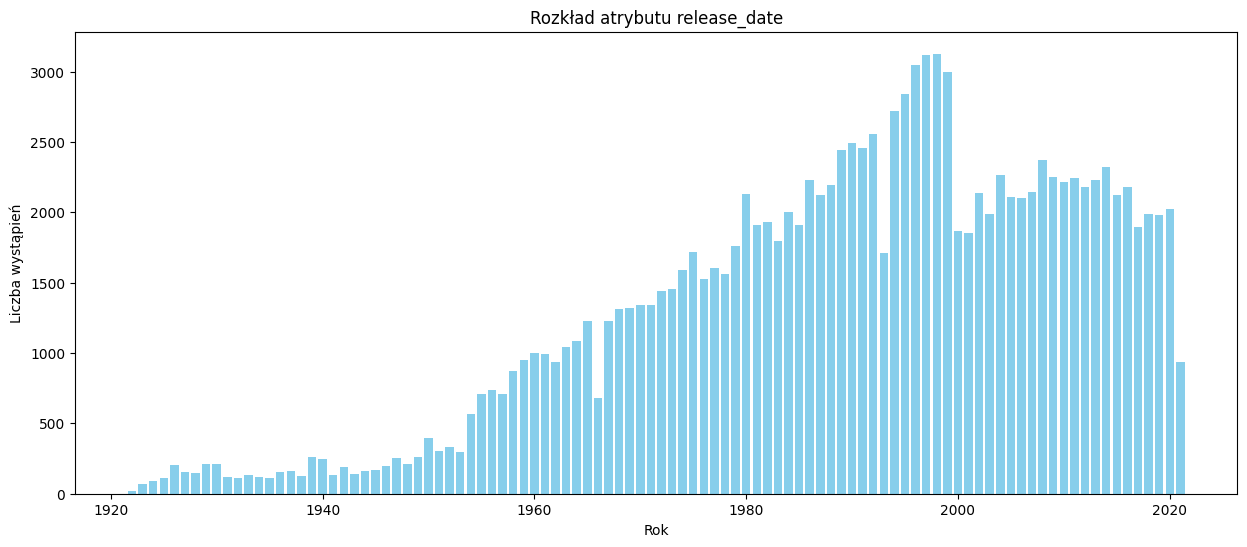

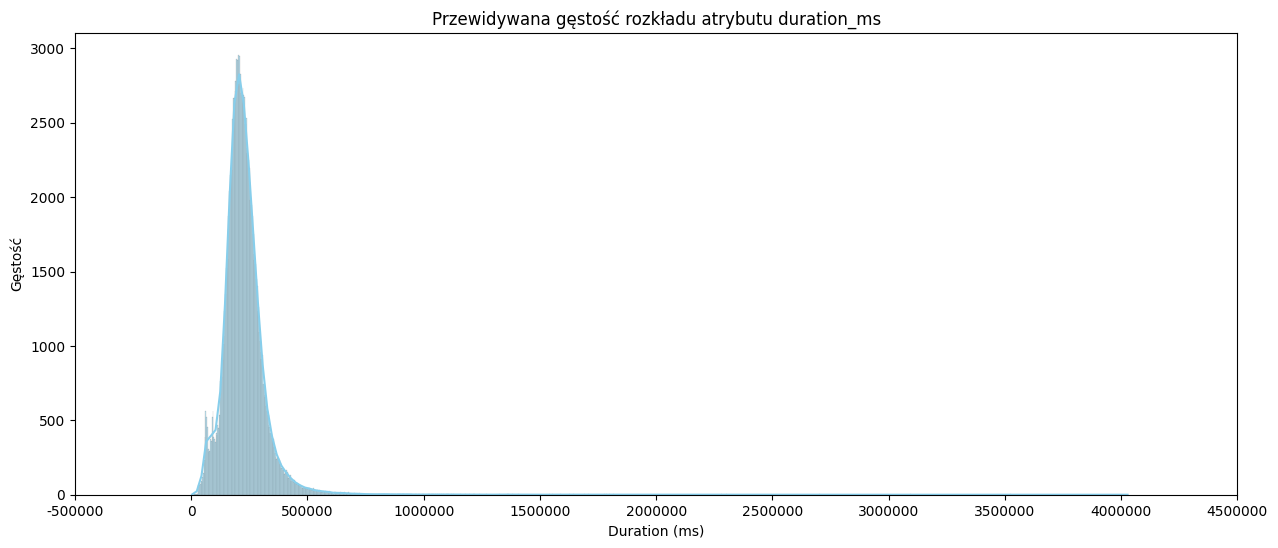

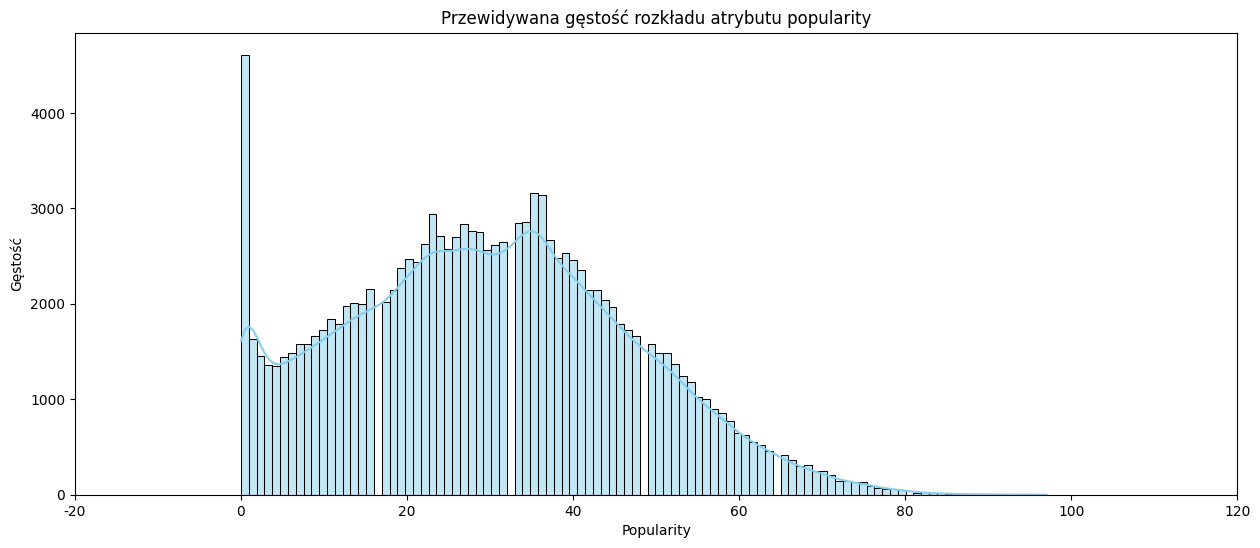

In [51]:
df_tracks = pd.read_json(jsonl_file_path_tracks, lines=True)
df_tracks["duration_ms"] = df_tracks["duration_ms"].astype('Int64')
df_tracks["popularity"] = df_tracks["popularity"].astype('Int64')
df_tracks["release_date"] = pd.to_datetime(df_tracks["release_date"], format='mixed')

release_date = {}
for index, row in df_tracks.iterrows():
    year = row["release_date"].year
    if year not in release_date:
        release_date[year] = 1
    else:
        release_date[year] += 1
df_release_date = pd.DataFrame(list(release_date.items()), columns=['Year', 'Count'])
plt.figure(figsize=(15, 6))
plt.bar(df_release_date['Year'], df_release_date['Count'], color='skyblue')
plt.xlabel('Rok')
plt.ylabel('Liczba wystąpień')
plt.title('Rozkład atrybutu release_date')
plt.show()

plt.figure(figsize=(15, 6))
sns.histplot(df_tracks["duration_ms"], kde=True, color='skyblue')
plt.xticks(ticks=plt.xticks()[0], labels=[f"{int(x)}" for x in plt.xticks()[0]])
plt.xlabel('Duration (ms)')
plt.ylabel('Gęstość')
plt.title('Przewidywana gęstość rozkładu atrybutu duration_ms')
plt.show()

plt.figure(figsize=(15, 6))
sns.histplot(df_tracks["popularity"], kde=True, color='skyblue')
plt.xticks(ticks=plt.xticks()[0], labels=[f"{int(x)}" for x in plt.xticks()[0]])
plt.xlabel('Popularity')
plt.ylabel('Gęstość')
plt.title('Przewidywana gęstość rozkładu atrybutu popularity')
plt.show()

*Popularity* - z wykresu widzimy, że dane są zróżnicowane, nie są jednostajne, ale praktycznie każda wartość występuje znaczną liczbę razy. Najczęściej występuje wartość 0 - z analizy danych wynika, że prawdopodobnie oznacza to, że utwór nie był odsłuchiwany w trakcie roku.

#### Atrybuty zagregowane
**Tracks full info**   
1. *Likes*

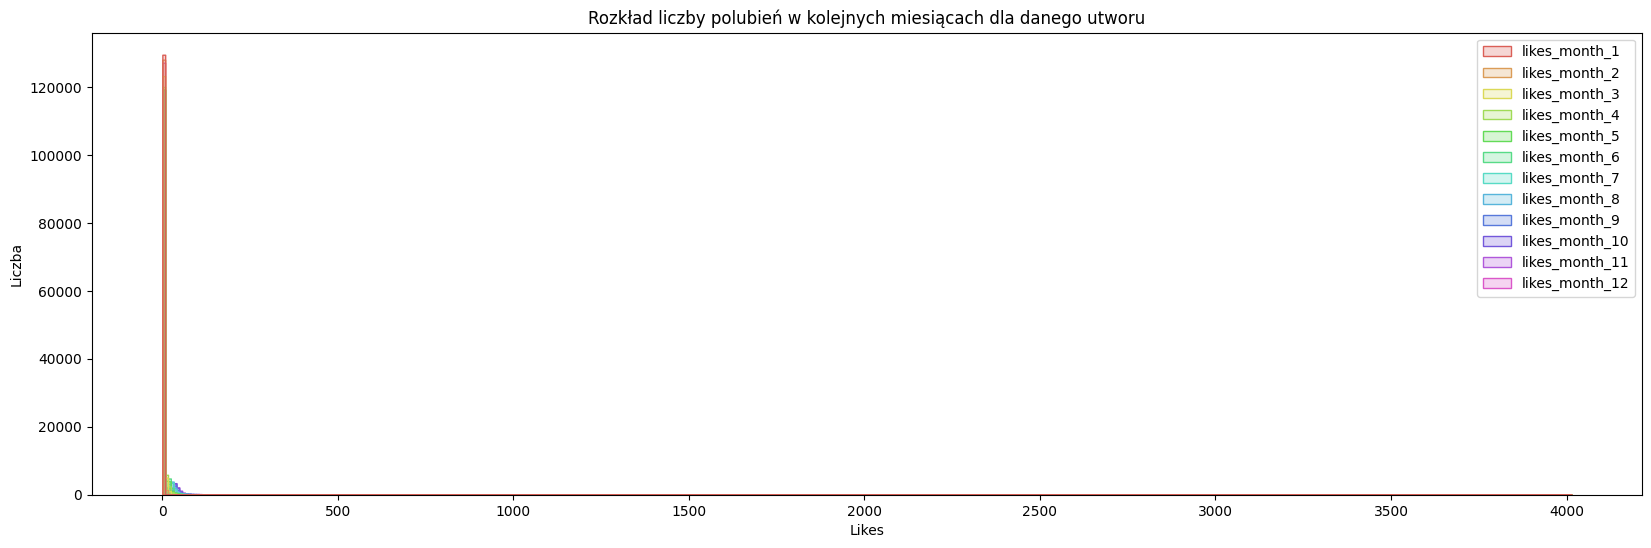

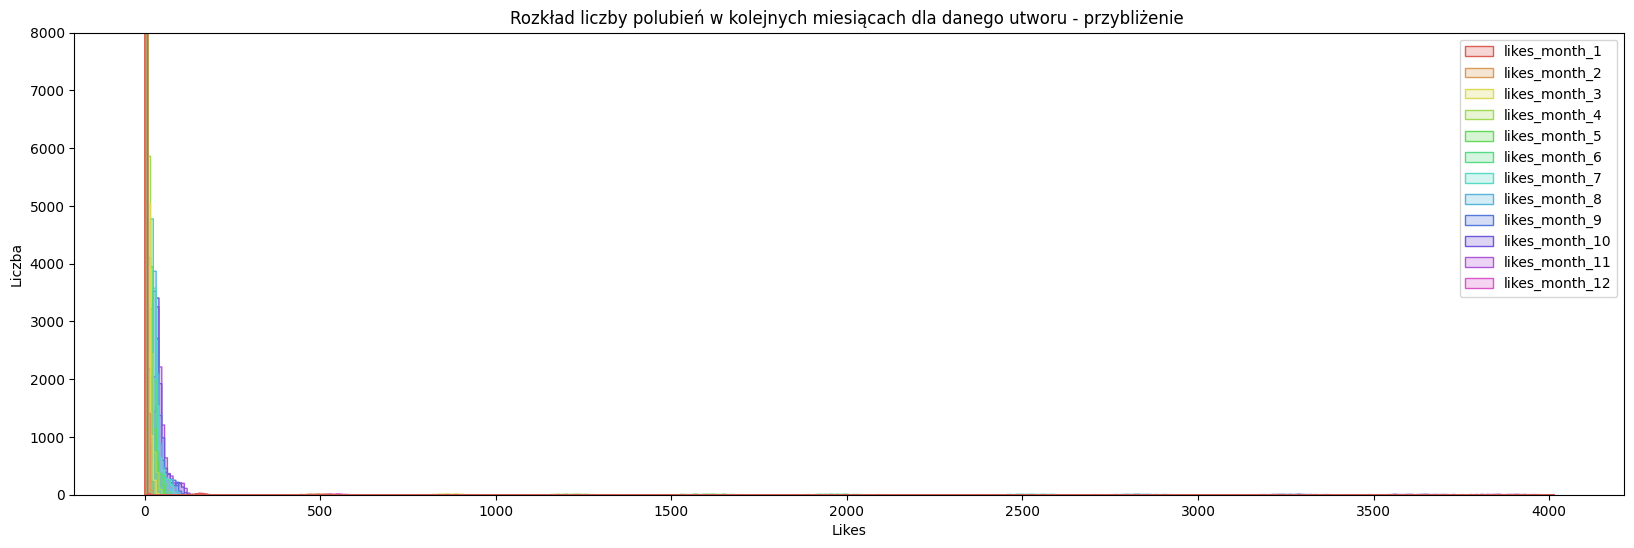

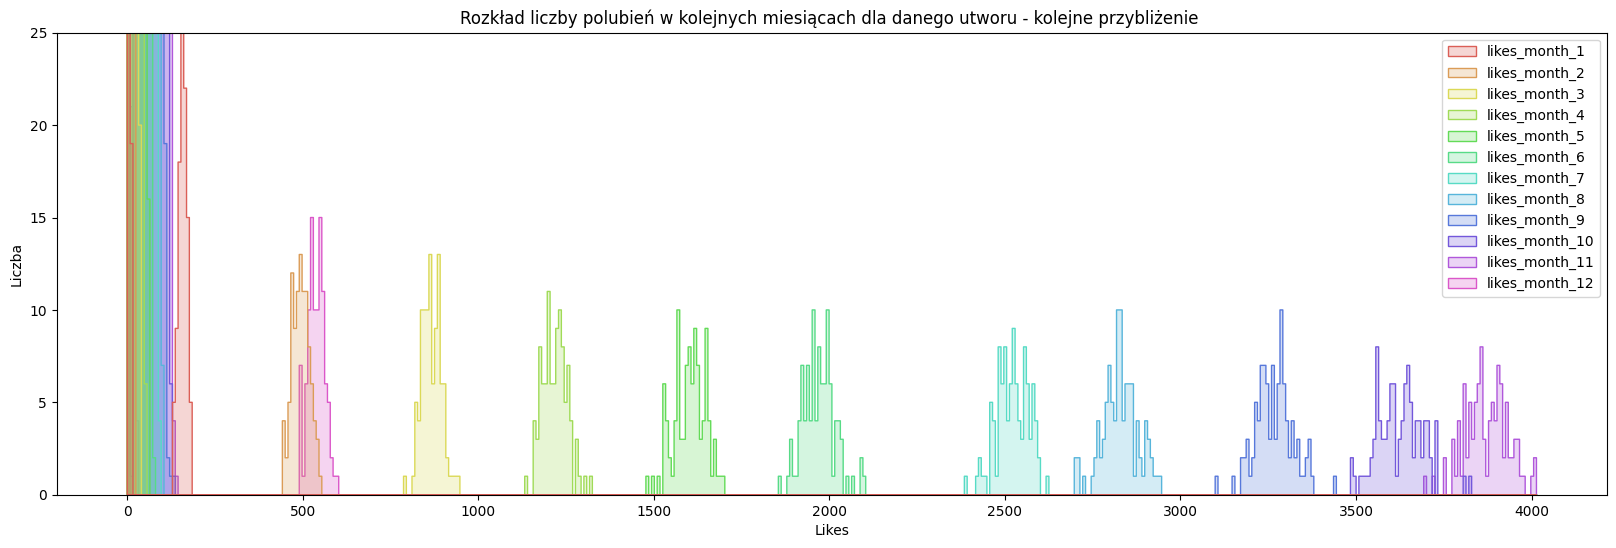

In [4]:
track_full_info = pd.read_json(jsonl_file_path_tracks_full_info, lines=True).set_index('track_id')

likes_columns = [f'likes_month_{i}' for i in range(1, 13)]
likes_data = track_full_info[likes_columns]
custom_palette = sns.color_palette("hls", 13)[:12]

plt.figure(figsize=(20, 6))
sns.histplot(likes_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Likes')
plt.ylabel('Liczba')
plt.title('Rozkład liczby polubień w kolejnych miesiącach dla danego utworu')
plt.show()

plt.figure(figsize=(20, 6))
sns.histplot(likes_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Likes')
plt.ylabel('Liczba')
plt.ylim(0, 8000)
plt.title('Rozkład liczby polubień w kolejnych miesiącach dla danego utworu - przybliżenie ')
plt.show()

plt.figure(figsize=(20, 6))
sns.histplot(likes_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Likes')
plt.ylabel('Liczba')
plt.ylim(0, 25)
plt.title('Rozkład liczby polubień w kolejnych miesiącach dla danego utworu - kolejne przybliżenie ')
plt.show()

*Likes* - histogramy liczby polubień w poszczególnych miesiącach wskazują, że użytkownicy byli bardziej aktywni w kolejnych miesiącach, pomijając grudzień. Tak jak w przypadku popularity, 0 jest najczęściej występującą wartością - jako, że wiele utworów nigdy nie było odsłuchiwanych.

2. *Time played*

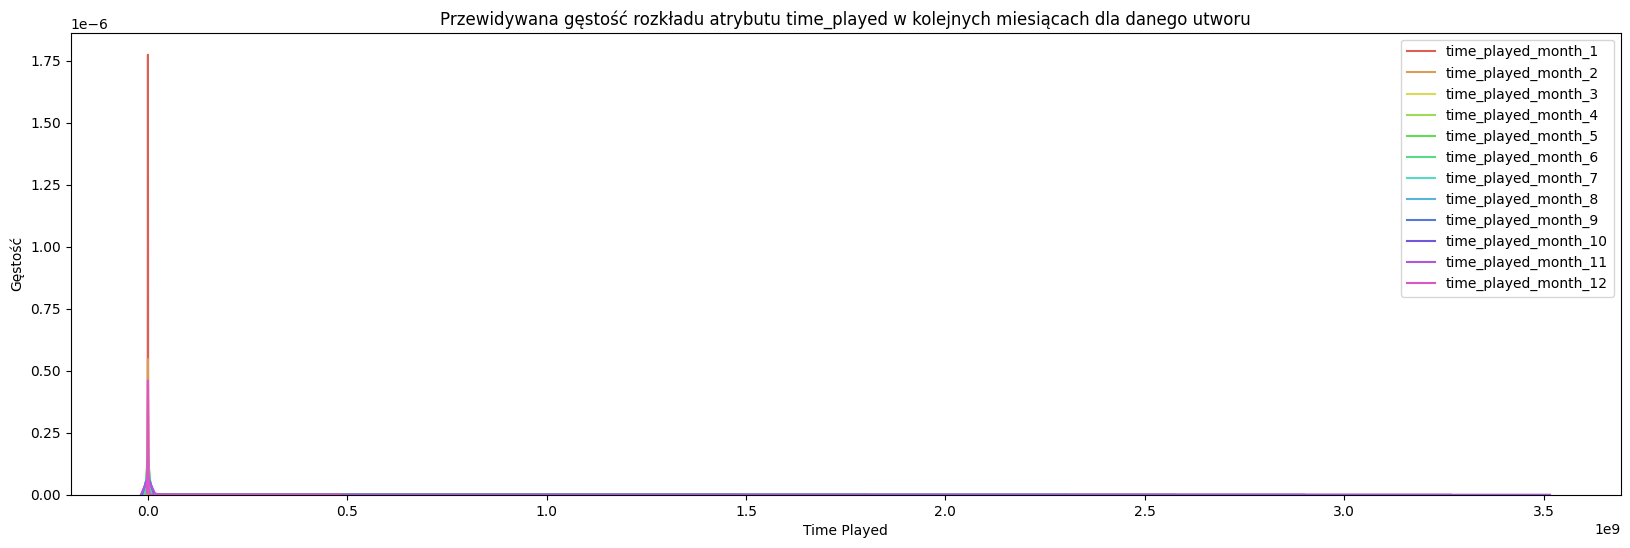

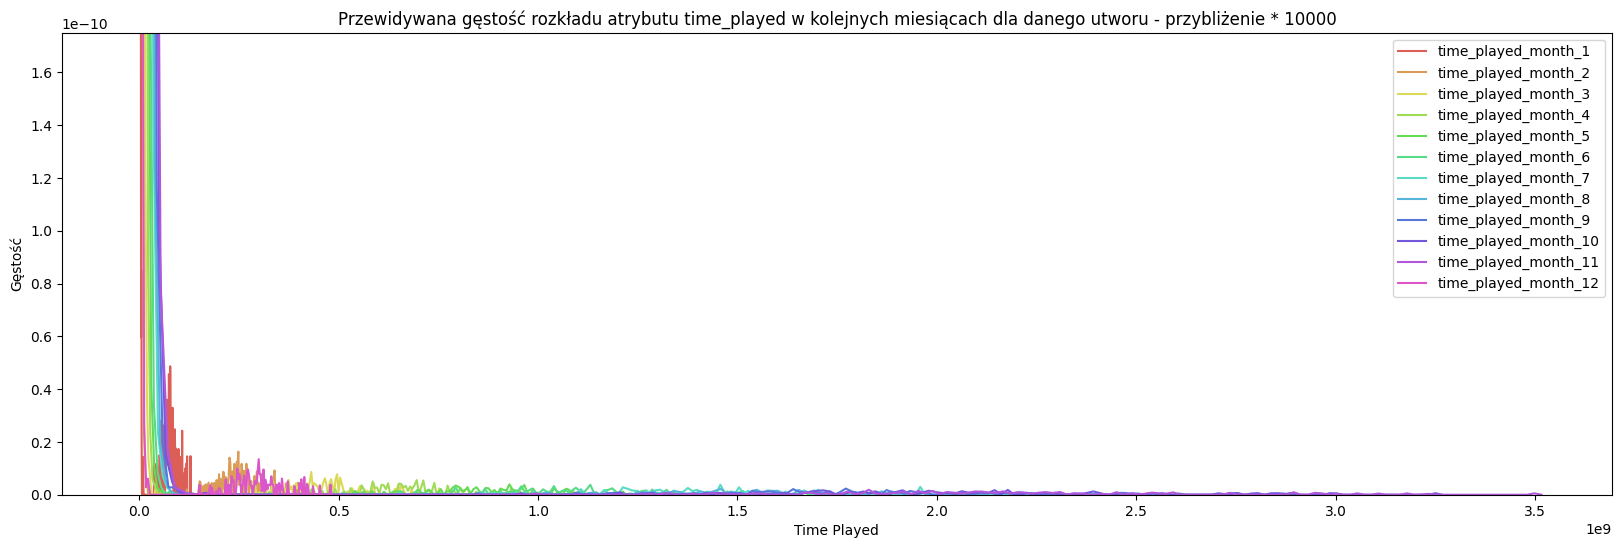

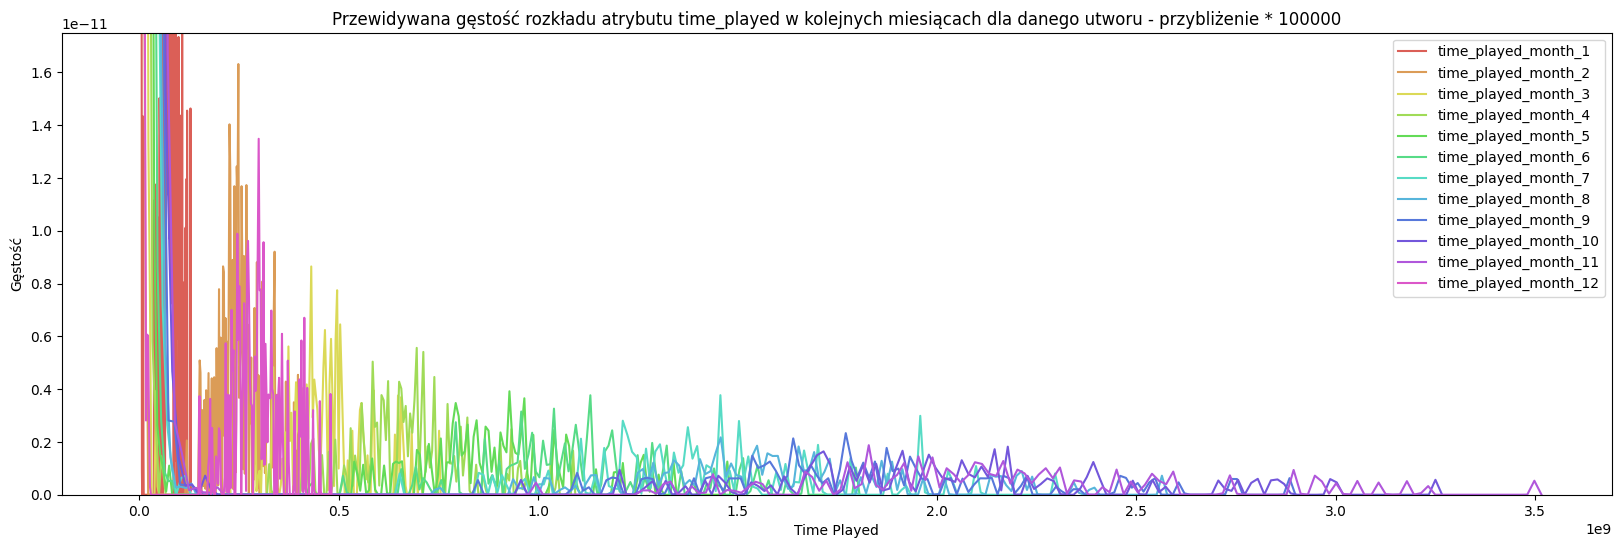

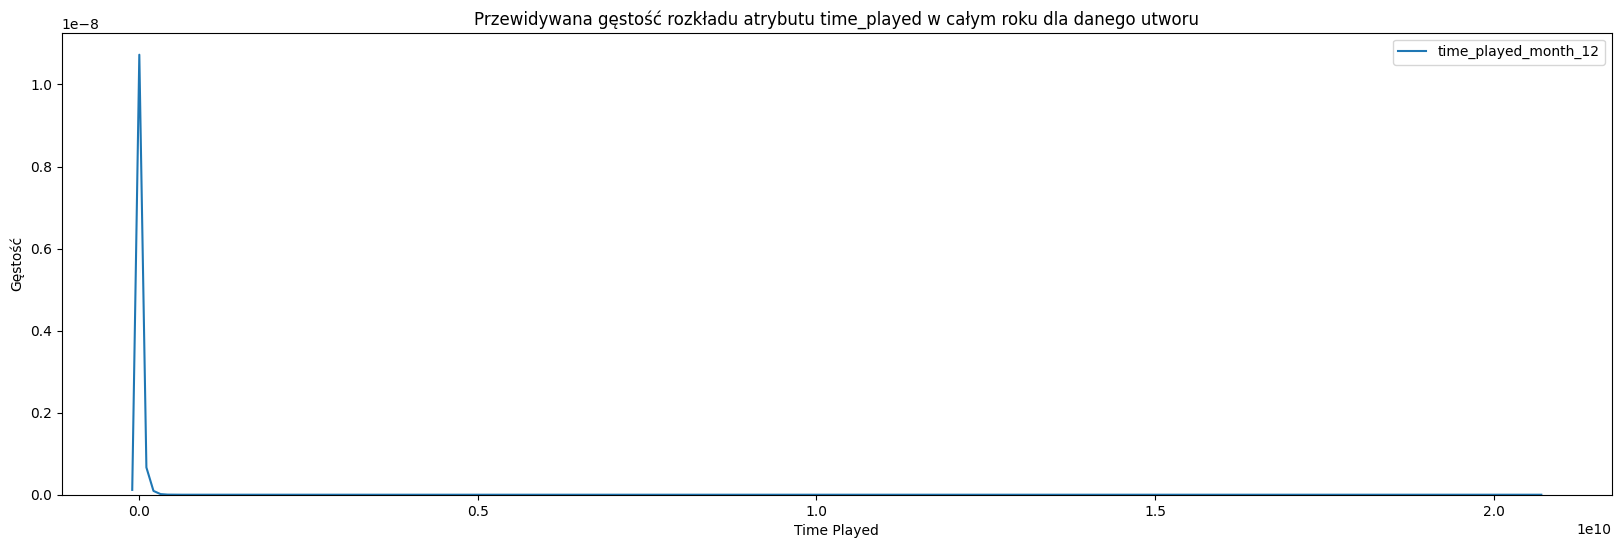

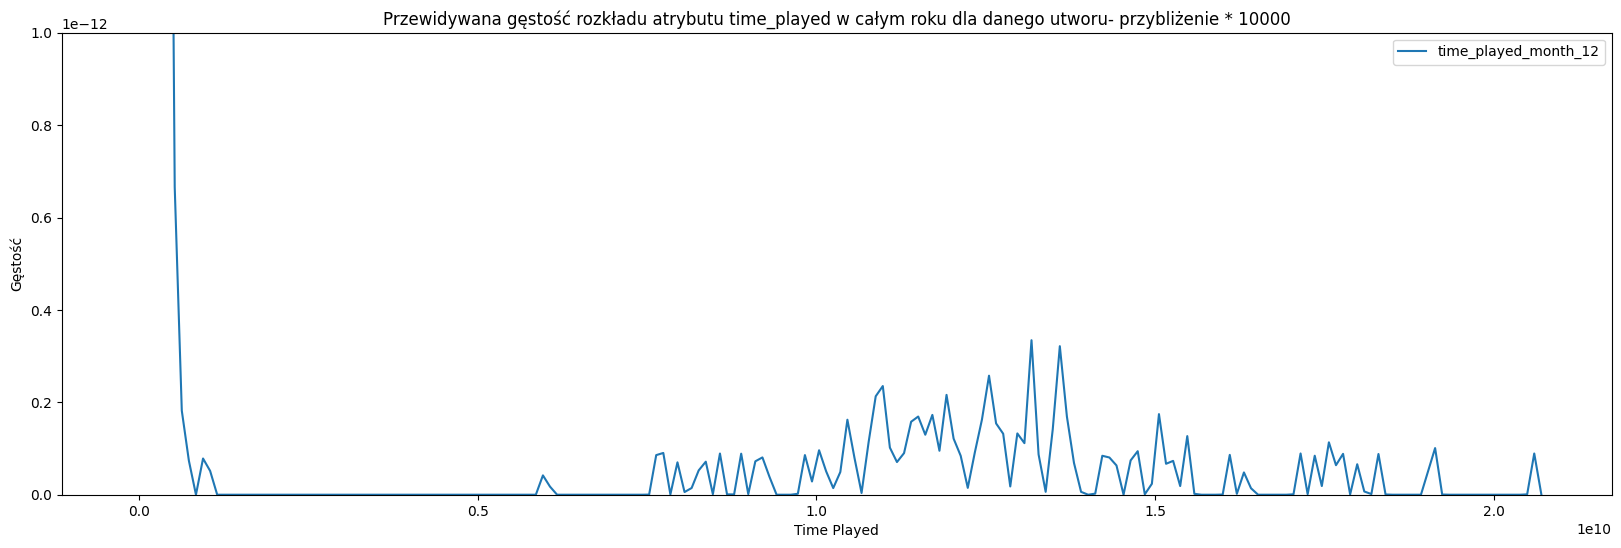

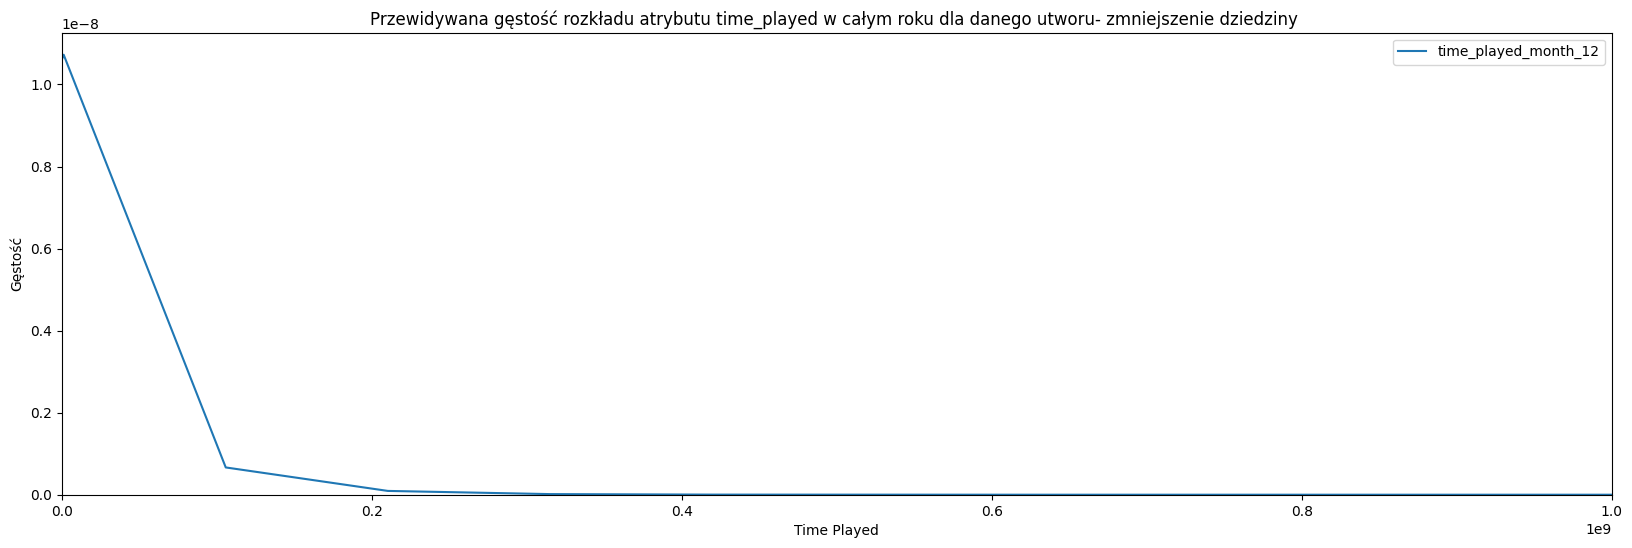

In [133]:
time_played_columns = [f'time_played_month_{i}' for i in range(1, 13)]
time_played_data = track_full_info[time_played_columns]
plt.figure(figsize=(20, 6))
for i, column in enumerate(time_played_data.columns):
    sns.kdeplot(time_played_data[column], label=column, fill=False, color=custom_palette[i])
plt.xlabel('Time Played')
plt.ylabel('Gęstość')
plt.title('Przewidywana gęstość rozkładu atrybutu time_played w kolejnych miesiącach dla danego utworu')
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
for i, column in enumerate(time_played_data.columns):
    sns.kdeplot(time_played_data[column], label=column, fill=False, color=custom_palette[i])
plt.xlabel('Time Played')
plt.ylabel('Gęstość')
plt.title('Przewidywana gęstość rozkładu atrybutu time_played w kolejnych miesiącach dla danego utworu - przybliżenie * 10000')
plt.legend()
plt.ylim(0, 1.75e-10)
plt.show()

plt.figure(figsize=(20, 6))
for i, column in enumerate(time_played_data.columns):
    sns.kdeplot(time_played_data[column], label=column, fill=False, color=custom_palette[i])
plt.xlabel('Time Played')
plt.ylabel('Gęstość')
plt.title('Przewidywana gęstość rozkładu atrybutu time_played w kolejnych miesiącach dla danego utworu - przybliżenie * 100000')
plt.legend()
plt.ylim(0, 1.75e-11)
plt.show()

all_time_played_data = pd.DataFrame()
all_time_played_data['time_played'] = track_full_info[time_played_columns].sum(axis=1)
plt.figure(figsize=(20, 6))
sns.kdeplot(all_time_played_data, label=column, fill=False, color=custom_palette[i])
plt.xlabel('Time Played')
plt.ylabel('Gęstość')
plt.title('Przewidywana gęstość rozkładu atrybutu time_played w całym roku dla danego utworu')
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
sns.kdeplot(all_time_played_data, label=column, fill=False, color=custom_palette[i])
plt.xlabel('Time Played')
plt.ylabel('Gęstość')
plt.title('Przewidywana gęstość rozkładu atrybutu time_played w całym roku dla danego utworu- przybliżenie * 10000')
plt.legend()
plt.ylim(0, 1.0e-12)
plt.show()

plt.figure(figsize=(20, 6))
sns.kdeplot(all_time_played_data, label=column, fill=False, color=custom_palette[i])
plt.xlabel('Time Played')
plt.ylabel('Gęstość')
plt.title('Przewidywana gęstość rozkładu atrybutu time_played w całym roku dla danego utworu- zmniejszenie dziedziny ')
plt.legend()
plt.xlim(0, 1.0e+8)
plt.show()



*Time played* - podobnie jak w przypadku atrybutu *likes*, widać, kiedy użytkownicy częściej korzystali z serwisu. Także, szczególnie na czwartym wykresie, widoczne jest to, że wiele utworów nigdy nie były odsłuchiwane. 

3. *Liczba oddtworzeń bez pominięć*

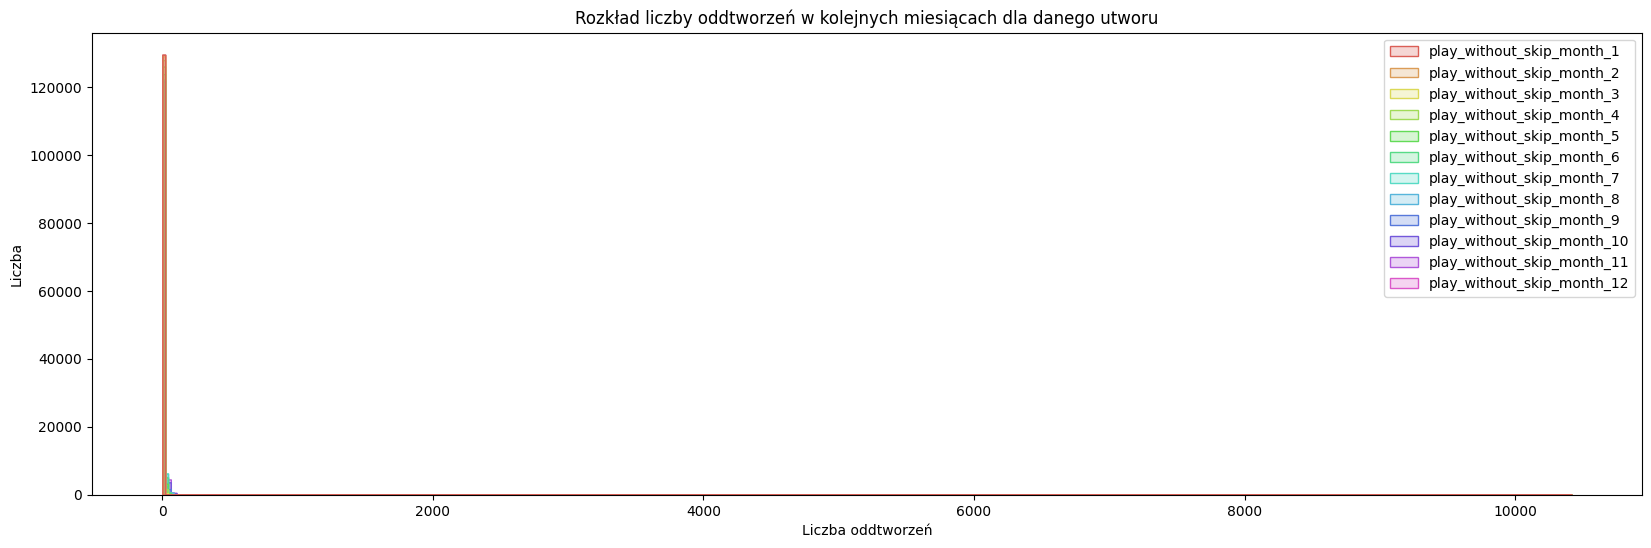

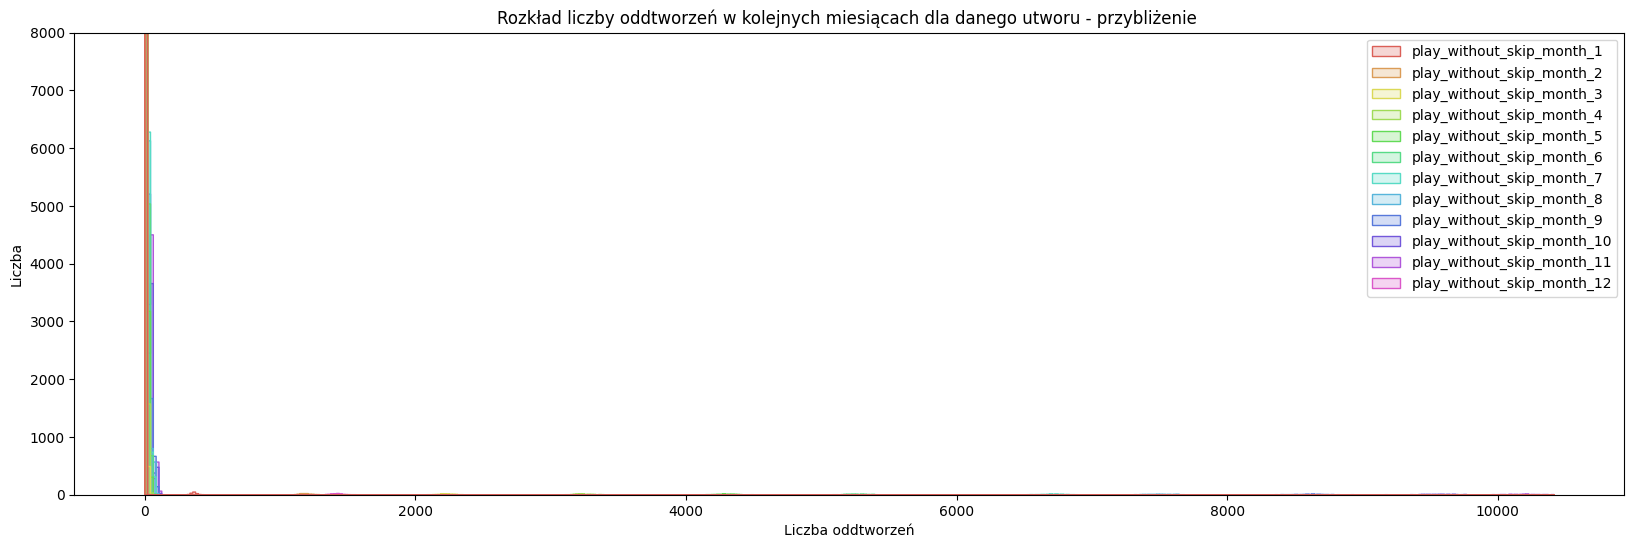

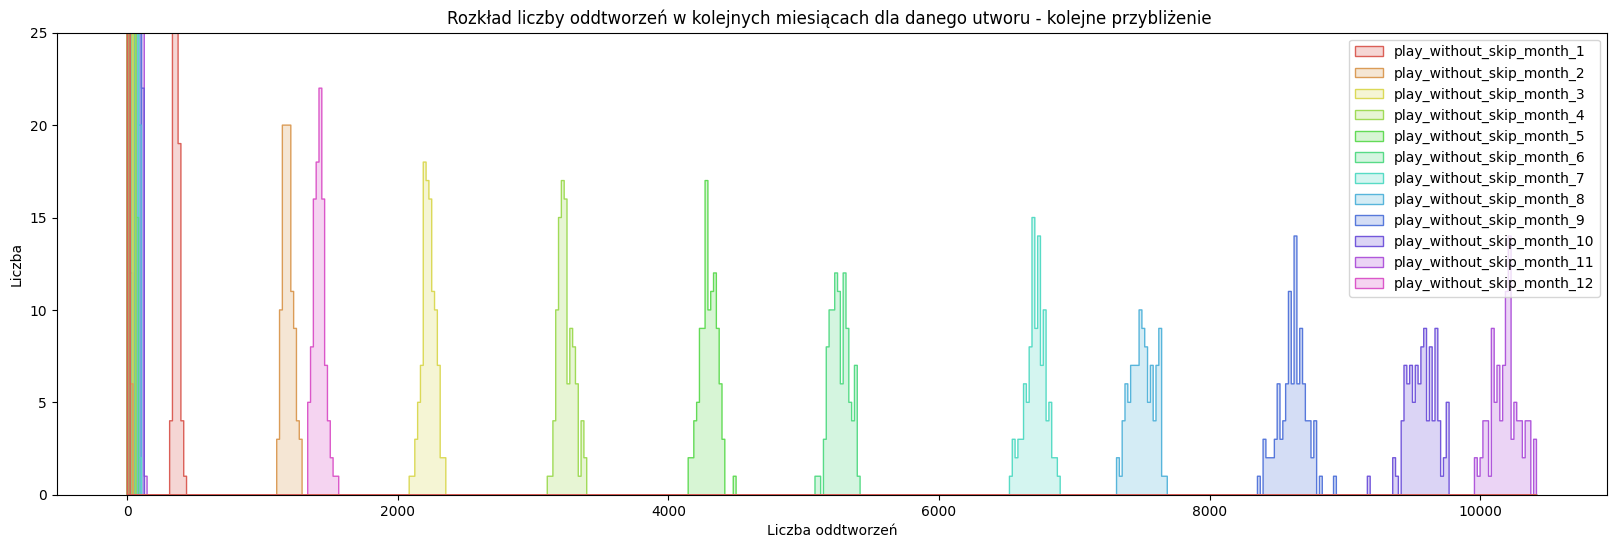

In [5]:
without_skip_columns = [f'play_without_skip_month_{i}' for i in range(1, 13)]
play_data = track_full_info[without_skip_columns]

plt.figure(figsize=(20, 6))
sns.histplot(play_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Liczba oddtworzeń')
plt.ylabel('Liczba')
plt.title('Rozkład liczby oddtworzeń w kolejnych miesiącach dla danego utworu')
plt.show()

plt.figure(figsize=(20, 6))
sns.histplot(play_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Liczba oddtworzeń')
plt.ylabel('Liczba')
plt.ylim(0, 8000)
plt.title('Rozkład liczby oddtworzeń w kolejnych miesiącach dla danego utworu - przybliżenie ')
plt.show()

plt.figure(figsize=(20, 6))
sns.histplot(play_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Liczba oddtworzeń')
plt.ylabel('Liczba')
plt.ylim(0, 25)
plt.title('Rozkład liczby oddtworzeń w kolejnych miesiącach dla danego utworu - kolejne przybliżenie ')
plt.show()

4. *Liczba pominięć*

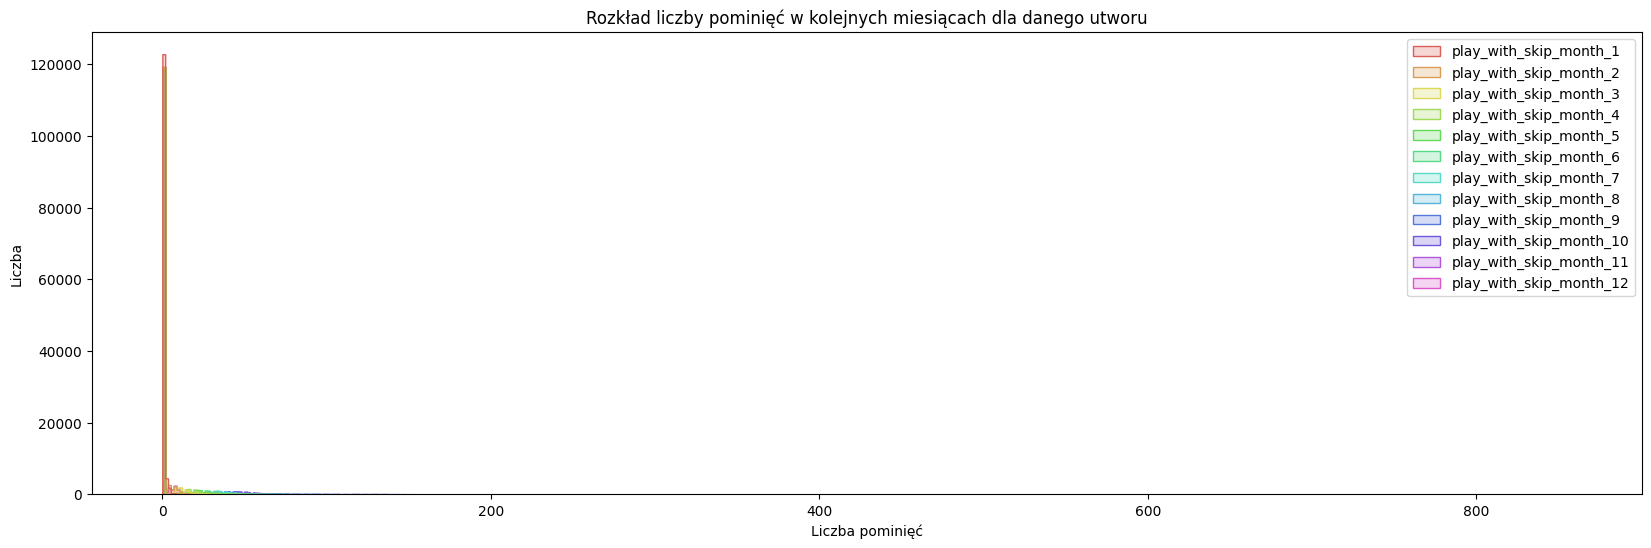

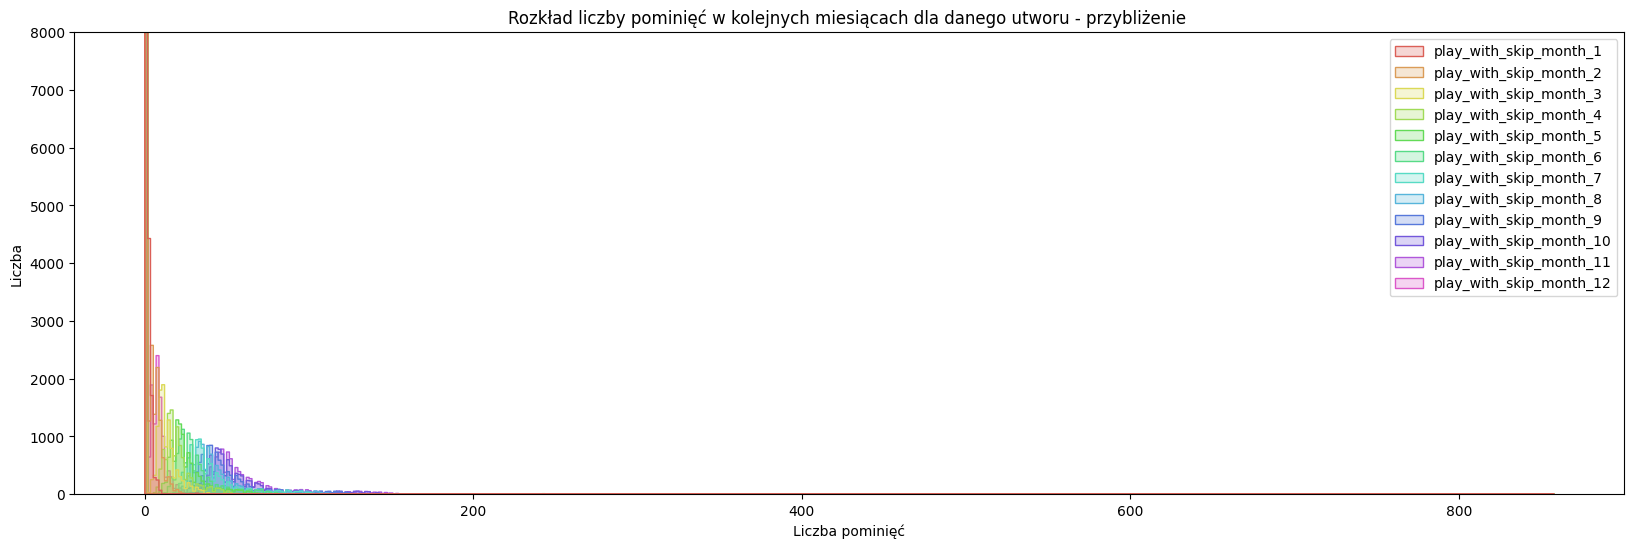

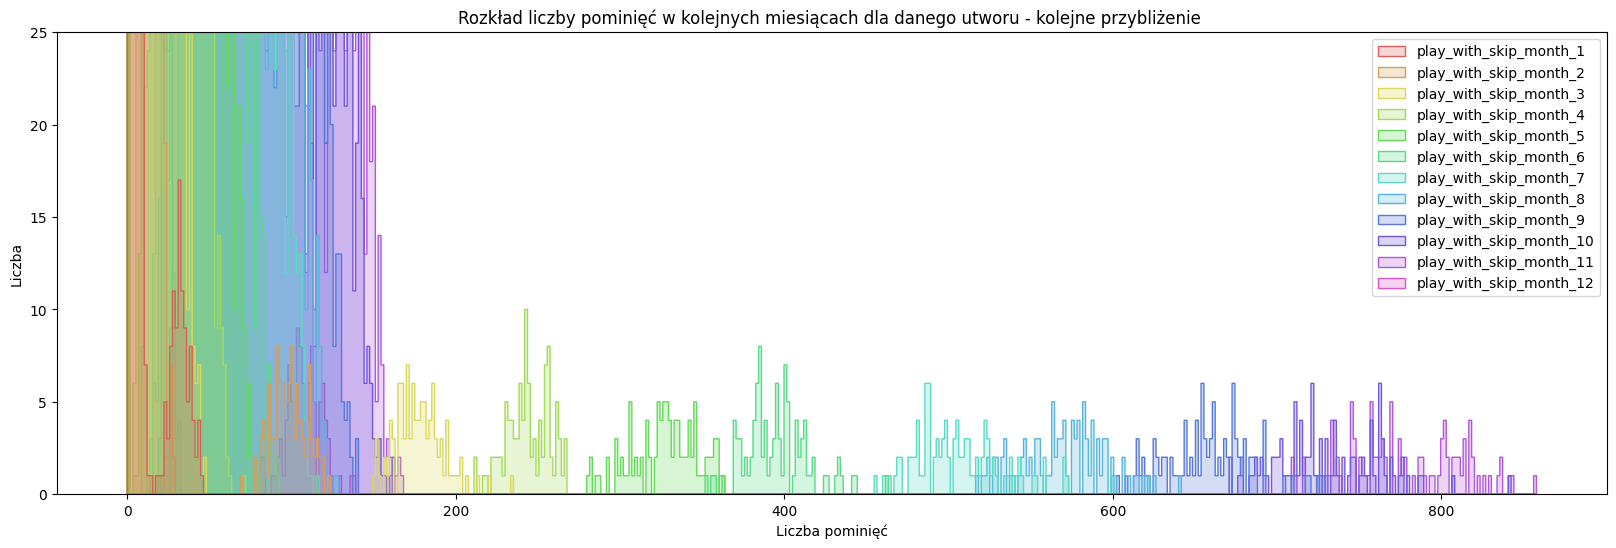

In [6]:
with_skip_columns = [f'play_with_skip_month_{i}' for i in range(1, 13)]
with_skip_data = track_full_info[with_skip_columns]

plt.figure(figsize=(20, 6))
sns.histplot(with_skip_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Liczba pominięć')
plt.ylabel('Liczba')
plt.title('Rozkład liczby pominięć w kolejnych miesiącach dla danego utworu')
plt.show()

plt.figure(figsize=(20, 6))
sns.histplot(with_skip_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Liczba pominięć')
plt.ylabel('Liczba')
plt.ylim(0, 8000)
plt.title('Rozkład liczby pominięć w kolejnych miesiącach dla danego utworu - przybliżenie ')
plt.show()

plt.figure(figsize=(20, 6))
sns.histplot(with_skip_data, bins=500, kde=False, element='step', palette=custom_palette)
plt.xlabel('Liczba pominięć')
plt.ylabel('Liczba')
plt.ylim(0, 25)
plt.title('Rozkład liczby pominięć w kolejnych miesiącach dla danego utworu - kolejne przybliżenie ')
plt.show()

*Play with/without skip* - znowu widoczne jest, kiedy użytkownicy byli bardziej aktywni. Widzimy też, że stosunkowo rzadko zdarzały się pominięcia utworów - zdecydowanie częściej utwory były odsłuchiwane w całości.

### Dane potrzebne do zadania:
- artists   
    - id - pozwala połączyć z innymi tabelami
- sessions
    - session_id - do obliczania czasu przesłuchania
    - timestamp - wskazuje kiedy coś się działo, dodatkowo ważne jeśli podejdziemy do zadania jako do zadania analizy szeregów czasowych.
    - track_id - pozwala połączyć z innymi tabelami
    - event_type - wskazuje ważne dla nas zdarzenia, w procesie uczenia nie będziemy brali pod uwagę zdarzeń: 'advertisement' i 'buy_premium'
        - like - utwór polubiony, zapewne będzie często jeszcze słuchany
        - play + skip - utwór się jednak nie podoba
        - play bez skip - cały utwór przesłuchany, podobał się 
- tracks
    - id - pozwala połączyć z innymi tabelami
    - popularity - im popularniejszy tym częściej słuchane
    

### Dane niepotrzebne do zadania:
- artists
    - name
    - genres - niektóre gatunki są częściej słuchane niż inne, jednakaże mamy za dużo unikalnych gatunków
- track_storage
    - informacje o cache'u, niepotrzebne nam
- sessions
    - session_id
    - user_id
- users
    - nie ma potrzeby wiedzieć kto co słucha tylko co jest słuchane
- tracks
    - name - nic nie wskazuje
    - explicit, key, danceability, ... <- to raczej do przypisywania do konkretnych gatunków, co nie jest naszym zadaniem
    - duration_ms - teoretycznie im dłuższy utwór tym dłuższy czas słuchania, jednakże
        1. trudno te dane zagregować
        2. mamy już dane jak długo danego artysty słuchano w poprzednich miesiącach
    - release_date - możliwe czasem stare utwory nie są już popularne, ale nie ma dużej możliwości agregacji tych danych (należałoby policzyć średnią?). Po wstępnym przetestowaniu uznaliśmy, że nie ma potrzeby używania tego atrybutu.
